### Computational Economics
Alexander Skorobogatov

# Topic 5. Credit Cycle Model
For the model, see [the original paper](https://www-users.york.ac.uk/~psm509/ULB2012/KiyotakiMooreJPE1997.pdf) by Nobuhiro Kiyotaki and John Moore

The code below is my Python version of their [Matlab code](https://ideas.repec.org/c/dge/qmrbcd/113.html) to reproduce the paper's results.

In [1]:
import numpy as np

# [1] Parameters
a   = 1;
phi = 20;
R   = 1.01;
lamda = 0.975;
pai = 0.1 ;  
v  = 2;
  
# SS Values

DKstar = (a + lamda*phi - phi)/(R-1);
qstar  = (R/(R-1))*(pai*a - (1-lamda)*(1- R + pai*R)*phi )/(lamda*pai + (1-lamda)*(1- R + pai*R));
xstar  = qstar * (R-1)/R;
Kstar  = xstar + v ;
Dstar  = DKstar * Kstar;
  
qKD = np.array([[qstar, Kstar, Dstar]]).transpose()

# Model

from sympy import symbols, Matrix
Dt, Kt, qt, Da, Ka, qa = symbols('Dt, Kt, qt, Da, Ka, qa')

capital =  (pai/(qt + phi -qa/R))*( (a+lamda*phi+qt)*Kt - R*Dt) + (1-pai)*lamda*Kt - Ka;
debt    =  R*Dt + qt*(Ka - Kt) + phi*(Ka-lamda*Kt) - a*Kt -Da;
euler   =  qt - qa/R - (Kt - v);

optc = Matrix([euler, debt, capital])

Y = Matrix([euler, debt, capital])
X = Matrix([Dt, Kt, qt, Da, Ka, qa])
Y.jacobian(X)

# Linearization

# Differentiation 
xx = Matrix([qt, Dt, Kt, qa, Da, Ka]) # define vars
jopt = optc.jacobian(xx)

# Evaluate each derivative

coef = jopt.subs([(qt,qstar),(Dt,Dstar),(Kt,Kstar),(qa,qstar),(Da,Dstar),(Ka,Kstar)])

# In terms of % deviations from ss    

vo = Matrix([qstar,Dstar,Kstar]).transpose()
TW = Matrix([vo,vo,vo])

C = np.multiply(-coef[:,0:3],TW)
B = np.multiply(coef[:,3:6],TW)

# C[q(t)  D(t)  K(t)] = B[q(t+1)  D(t+1)  K(t+1)]
A = np.dot(np.linalg.inv(C.astype('f4')),B)

# Solution proc
# [2] EIGEN DECOMPOSITION

theta = np.linalg.eig(A.astype('f4'))[0]
W = np.linalg.eig(A.astype('f4'))[1]
Q = np.linalg.inv(W)
V = np.diag(theta)

# Extract stable vectors

SQ = np.zeros((3,3),dtype=complex)
for i in range(len(theta)):
    if abs(theta[i])>1.000000001:
        SQ[i] = Q[i]
SQ=SQ[~np.all(SQ == 0, axis=1)]

# Extract unstable vectors

UQ = np.zeros((3,3),dtype=complex)
for i in range(len(theta)):
    if abs(theta[i])<1.000000001:
        UQ[i] = Q[i]
UQ=UQ[~np.all(UQ == 0, axis=1)]

# Extract stable roots (lamda>1)

VLL = np.zeros((1,3),dtype=complex)
for i in range(len(theta)):
    if abs(theta[i])>1.000000001:
        VLL[0,i] = theta[i]
VLL=VLL.compress(np.all(VLL != 0, axis=0),axis=1)

# Show Eigen Vectors on U-S Roots
print(UQ)
print(SQ)

# [3] ELIMINATING UNSTABLE VECTORS

k = len(SQ) # of predetermined vars
n = len(UQ) # of jump vars
nk = np.array([(n,k)])

# Stable V (eig mat)

VLLL = np.zeros((2,2),dtype=complex)
for i in range(k):
    VLLL[:,[i]] = VLL[0,i]*np.ones((k,1))

VL = np.linalg.inv(np.identity(k)*VLLL)  # modified inverse!!

# Elements in Q

PA = UQ[n-1,n-1]
PB = UQ[:,n:n+k]
PC = SQ[0:k,0:n]
PD = SQ[0:k,n:n+k]
P = np.multiply((-1/PA),PB) # X(t) = P*S(t)
PE = PC*P+PD

# SOLUTION
PX = np.dot(np.dot(np.linalg.inv(PE),VL),PE)
AA = PX.real

# SIMULATION PROGRAM
# [4] TIME&INITIAL VALUES 

t = 80 # Time span you want to simulate   

# Initial Values 
# state var + e

S1 = np.array([[0, 0.01]]).transpose()

#  Random diturbances

sig = 0 # stop stochastic sim if sig = 0
e = np.zeros((t,k))

# [5] SIMULATION 
Ss = S1
S = np.zeros((t,k))
for i in range(t):
    q = np.dot(AA,Ss)
    S[i] = q.transpose()
    Ss = S[i].transpose()
    
SY = np.concatenate((S1.transpose(), S))
X = np.dot(P.real,SY.transpose())

[[-0.13323016+0.00000000e+00j -1.23373508-3.21752351e-18j
   1.85477602+0.00000000e+00j]]
[[ 0.0608028 -2.70634556j -0.05565742+2.47729874j -0.84647185-2.9944315j ]
 [ 0.0608028 +2.70634556j -0.05565742-2.47729874j -0.84647185+2.9944315j ]]


In [2]:
# [6] DRAWING FIGURES
# %% Recovering Jump variables
# %% SY = [Dt Kt]
# %% X  = [qt]

qs = X[0]
Ks = SY[:,1]
Ds = SY[:,0]

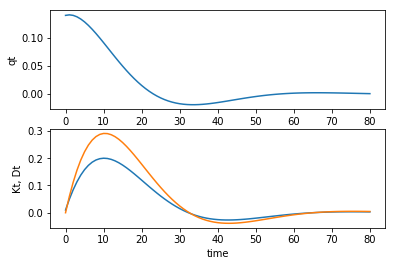

In [4]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(2, 1, 1)
plt.plot(qs)
plt.xlabel('time')
plt.ylabel('qt')

plt.subplot(2, 1, 2)
plt.plot(Ks)
plt.plot(Ds)
plt.xlabel('time')
plt.ylabel('Kt, Dt')
plt.show()